In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.misc import derivative
from scipy.optimize import brent, fsolve, fminbound
from scipy.special import ndtr
from scipy.stats import norm

from sympy import diff, symbols, exp, log, lambdify
from sympy.solvers import solve

# Example 1: Random samples from a normal distribution

**pdf**: $\large \displaystyle f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

**log likelihood function**: $\displaystyle \large \mathcal{L}(\mu,\sigma|\mathbf{x}) = \sum_{i=1}^{n} \log(f(x_i|\mu, \sigma))$ where $\mathbf{x} = (x_1, x_2, \dots, x_n)$

In [2]:
def normpdf_mean(mu, sig, sample):
    return norm.pdf(sample, mu, sig)

def normpdf_std(sig, mu, sample):
    return norm.pdf(sample, mu, sig)

In [3]:
rng = np.random.default_rng(0)
normals = rng.normal(size=100000)

In [4]:
def llf(x0, f, samples, *args):
    result = np.log(f(x0, *args, samples)).sum()
    return result

def llf_neg(x0, f, samples, *args):
    return -llf(x0, f, samples, *args)

In [22]:
xx = np.linspace(-3,3,10000)
yy = np.array([llf(i, normpdf_mean, normals, 1.) for i in xx] )

In [49]:
xx = np.linspace(5e-1,3,10000)
yy = np.array([llf(i, normpdf_std, normals, normals.mean()) for i in xx] )

In [5]:
print('mle for mean:', brent(llf_neg, args = (normpdf_mean, normals, normals.std()), brack=(-1.,.0,1.)))

mle for mean: -0.0009082625895204994


In [6]:
print('mle for std:', brent(llf_neg, args = (normpdf_std, normals, normals.mean()), brack=(.5,1.,2.)))

mle for std: 1.0001285193693108


In [7]:
xx = np.linspace(5e-1,3,10000)
yy = np.array([llf(i, normpdf_std, normals, normals.mean()) for i in xx] )

In [11]:
xx_m = np.linspace(-1.5,1.5,10000)
yy_m = np.array([llf(i, normpdf_mean, normals, normals.std()) for i in xx_m] )

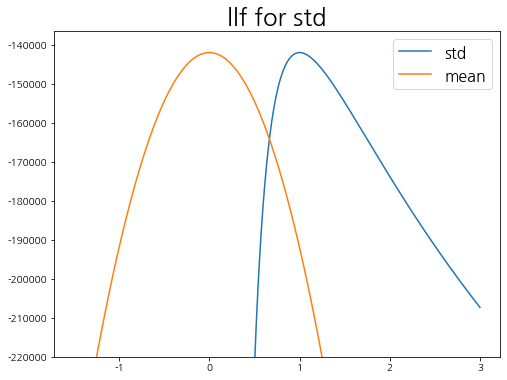

In [16]:
plt.figure(figsize=(8,6))
plt.plot(xx, yy, label = 'std')
plt.plot(xx_m, yy_m, label = 'mean')
plt.ylim(bottom=-2.2e+5)
#plt.scatter()
plt.title('llf for std', fontsize=24)
plt.legend(fontsize=16)
plt.show()

In [10]:
brent(llf_neg, args = (normpdf_mean, normals, normals.std()), brack=(-1.,.0,1.), full_output=True)

(-0.0009082625895204994, 141906.70290018787, 36, 40)

In [9]:
brent(llf_neg, args = (normpdf_std, normals, normals.mean()), brack=(.5,1.,2.), full_output=True)

(1.0001285193693108, 141906.7029001879, 12, 16)

# Example 2

**pdf**: $\large f(x) = \theta e^{-\theta x}$

**log likelihood function**: $\displaystyle \large \sum_{i=1}^{n} \log(f(x_i|\theta))$ where $\mathbf{x} = (x_1, x_2, \dots, x_n)$

## by sympy

In [2]:
def pdf(theta, x):
    return theta * exp(-theta*x)

In [4]:
def llf(x0, f, samples):
    result = 0
    for s in samples:
        result += log(f(x0, s))
    return result

In [5]:
x = symbols('x')

In [6]:
y = llf(x, pdf, [3,3,3,1,2])

* Find $\theta$ s.t. $\large \displaystyle \frac{\partial \mathcal{L}(\theta|\mathbf{x})}{\partial \theta}=0$

In [34]:
print(solve(y.diff(x, 1), x))

[5/12]


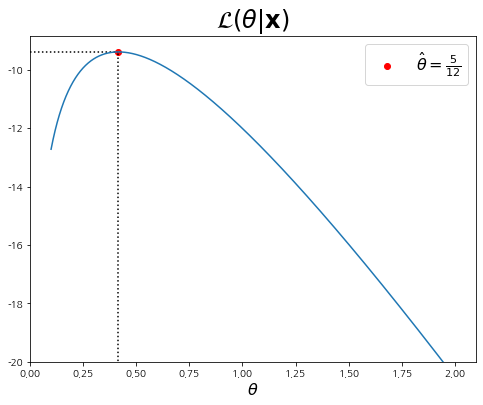

In [33]:
ff  = lambdify(x, y, 'numpy')
xx = np.linspace(0.1, 2, 10000)
yy = ff(xx)
mle = np.array(solve(y.diff(x, 1), x), dtype = np.float64)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.vlines(mle, yy.min(), yy.max(), linestyle=':', linewidth=1.5, color='k')
ax.hlines(ff(mle), .0, mle, linestyle=':', linewidth=1.5, color='k')
ax.plot(xx, yy)
ax.scatter(mle, ff(mle), color='r', label = r'$\hat\theta=\frac{{{}}}{{{}}}$'.format( *str(solve(y.diff(x, 1), x)[0]).split('/') ) )
plt.title(r'$\mathcal{L}( \theta | \mathbf{x})$', fontsize=24)
plt.xlabel(r'$\theta$', fontsize=16)
plt.legend(fontsize=16)
ax.set_xlim(left=0)
ax.set_ylim(bottom=-20)
plt.show()

## by scipy

In [9]:
def pdf_(theta, x):
    return theta * np.exp(-theta*x)

In [10]:
def llf_(x0, f, samples):
    result = 0
    for s in samples:
        result += np.log(f(x0, s))
    return result

In [11]:
xx_ = np.linspace(.1, 2, 1000)
yy_ = np.array([llf(i, pdf_, [3,3,3,1,2]) for i in xx_])

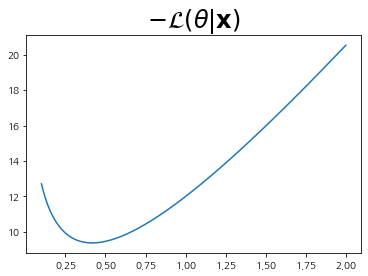

In [12]:
plt.plot(xx_, -yy_)
plt.title(r'$-\mathcal{L}( \theta | \mathbf{x})$', fontsize=24)
plt.show()

* Find $\theta$ s.t.  $\large \underset{\theta}{\mathrm{arg min}}\, -\mathcal{L}(\theta|\mathbf{x})$

In [15]:
def llf_neg_(x0, f, samples):
    return -llf_(x0, f, samples)

In [35]:
print('mle by brent method:',brent(llf_neg_, args=(pdf_, [3,3,3,1,2]), brack=(.1, .4,  2.)) )

mle by brent method: 0.41666666687827514


In [36]:
print('mle by bounded minimization:',fminbound(llf_neg_, .0, 2., args=(pdf_, [3,3,3,1,2])))

mle by bounded minimization: 0.4166652644065801
